Import dependencies:

In [1]:
import numpy as np
import numexpr as ne

#import os
import importlib

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['font.size'] = 9

import astropy.io
import astropy.units as u

import poppy
import pyfftw
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARN)



%matplotlib inline


pyculib:1: ImportWarning: Numba version too old; expecting 0.33.0


Print the this notebook's current git commit

In [2]:
%%bash
git rev-parse HEAD


5e2c0436e2678b37a91527a266a46ab4a310ca3c


## Print system info

### Software versions

In [3]:
from  poppy.accel_math import  _USE_CUDA, _USE_NUMEXPR, _FFTW_AVAILABLE

print(_USE_CUDA, _USE_NUMEXPR,_FFTW_AVAILABLE)
print("current POPPY version: "+str(poppy.__version__))


True True True
current POPPY version: 0.6.2.dev1158


In [4]:
print(np.__version__)
print(np.__config__.show())

1.11.2
blas_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/include']
openblas_lapack_info:
  NOT AVAILABLE
lapack_mkl_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/include']
lapack_opt_info:
    libraries = ['

In [5]:
print("NumExpr info")
print(ne.__version__)
ne.ncores,ne.nthreads,ne.show_config()

NumExpr info
2.6.1
mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/poppyenv/include']


(12, 8, None)

In [6]:
print("FFTW info")
print(pyfftw.version)


FFTW info
0.9.2


### Hardware info

In [7]:
%%bash
cat /proc/cpuinfo | grep 'model name' | uniq
cat /proc/cpuinfo | grep 'cpu family' | uniq
 lscpu | grep 'Model:' | uniq
 lscpu | egrep '^Thread|^Core|^Socket|^CPU\('



model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu family	: 6
Model:                 79
CPU(s):                12
Thread(s) per core:    2
Core(s) per socket:    6
Socket(s):             1


In [8]:
%%bash
nvidia-smi



Thu May 17 13:22:51 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |     99MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Benchmark some useful math

In [9]:
n=4096
y=np.ones([n,n],dtype=np.complex128)
x=2*np.ones([n,n],dtype=np.complex128)
x64bit=2*np.ones([n,n],dtype=np.complex64)

y64bit=2*np.ones([n,n],dtype=np.complex64)

z=9#2*np.ones([n,n])#*1.j



In [10]:
print("NumPy:")
%timeit np.exp((x**2 + y**2)/z)

try:
    import numba
    import cmath
    dtype=numba.complex128
    @numba.vectorize([dtype(dtype,dtype,dtype)],)
    def fexp(x, y,z):
        return cmath.exp((x**2 + y**2)/z)
    print("Numba optimized w/o GPU:")
    %timeit fexp(x,y,z) #numba optimized
except Exception as err:
    print(err)
    
try:
    import numba
    @numba.vectorize([numba.complex128(numba.float64,numba.float64,
                            numba.float64,numba.float64,
                            numba.float64,numba.float64)],
          target="parallel")
    
    def f_xyz_def(xr,xi,
         yr,yi,
         zr,zi):
        x=complex(xr,xi)

        y=complex(yr,yi)

        z=complex(zr,zi)
        return cmath.cos((x**2+y**2)/z) + 1j*cmath.sin((x**2+y**2)/z)
        #return cmath.exp((x**2+y**2)/z)
    print("Numba Optimized with GPU:")
    %timeit f_xyz_def(x.real,x.imag,y.real,y.imag,z.real,z.imag)
except Exception as err:
    print(err)


print("numexpr optimized:")
%timeit ne.evaluate("exp((x**2 + y**2)/z)")




NumPy:
1.59 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba optimized w/o GPU:
834 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba Optimized with GPU:
273 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
numexpr optimized:
119 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
x.shape

(4096, 4096)

In [12]:
#confirm that exponents are faster than trigonometry

%timeit ne.evaluate("exp(x)")
%timeit ne.evaluate("cos(x)+1j*sin(x)")
%timeit np.exp(x)
%timeit np.cos(x)+1j*np.sin(x)

83.4 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
831 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
718 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.39 s ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
try:
    try:
        import pyculib as cuda
    except:
        print("failed to import pyculib FFT package")
        import accelerate.cuda as cuda

    print("unplanned CUDA FFT:")
    t=%timeit -o cuda.fft.ifft(y,out=x)
    print("unplanned CUDA FFT, 64 bit complex:")
    %timeit cuda.fft.ifft(y64bit,out=x64bit)
    
    plan=cuda.fft.FFTPlan(y.shape,np.complex128,np.complex128)
    plan64=cuda.fft.FFTPlan(x64bit.shape,np.complex64,np.complex64)
    print("planned CUDA FFT:")
    %timeit plan.inverse(y,out=x)
    print("planned CUDA FFT, 64 bit complex:")
    %timeit plan64.inverse(x64bit,out=y64bit)



except Exception as err:
    print(err)
    
try:
    import pyfftw
    print("pyFFTW 32 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=32)
    print("pyFFTW 32 threads, 64 bit complex:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(x64bit,threads=32)
    print("pyFFTW 16 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=16)
except Exception as err:
    print(err)
    
print("numpy FFT:")
%timeit np.fft.ifft2(y)
print("numpy FFT, 64 bit complex: ")
%timeit np.fft.ifft2(x64bit)

unplanned CUDA FFT:
142 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
unplanned CUDA FFT, 64 bit complex:
71.7 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
planned CUDA FFT:
137 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
planned CUDA FFT, 64 bit complex:
69.1 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
pyFFTW 32 threads:
786 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pyFFTW 32 threads, 64 bit complex:
409 ms ± 886 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
pyFFTW 16 threads:
786 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numpy FFT:
2.1 s ± 8.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numpy FFT, 64 bit complex: 
2.04 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:

import pyculib
import accelerate.cuda 
%timeit -o accelerate.cuda.fft.ifft(y,out=x)
%timeit -o pyculib.fft.ifft(y,out=x)




99.7 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.9 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 98.9 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [15]:
# Test FFT shifts
%timeit np.fft.fftshift(x)
%timeit poppy.accel_math._fftshift(x)
array8192=np.ones([8192,8192],dtype=np.complex128)

npshift_t= %timeit -o np.fft.fftshift(array8192)
try:
    cudashift_t=%timeit -o poppy.accel_math._fftshift(array8192)
except Exception as err:
    print(err)



443 ms ± 638 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
82.4 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.77 s ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
326 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
#fraunhofer system
osys_fraun = poppy.OpticalSystem(npix=2048,oversample=4)
osys_fraun.add_pupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
osys_fraun.add_detector(pixelscale=0.010, fov_arcsec=2.0)  # image plane coordinates in arcseconds

%timeit psf = osys_fraun.calc_psf(2e-6,display_intermediates=False)# wavelength in microns


551 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define test system

In [17]:
intermediate=  poppy.poppy_core.PlaneType.intermediate 
wavelen = 770e-9

D_prim = 2.37 * u.m
fr_pri = 7.8
fl_pri = D_prim * fr_pri

D_relay = 20 * u.mm
fl_m2 = fl_pri * D_relay / D_prim
fr_m3 = 20.
fl_m3 = fr_m3 * D_relay

def optsys(npix=1024,ratio=0.25):
    '''
    initiate a WFIRST-like 3 mirror system
    
    '''
    
    optsys = poppy.FresnelOpticalSystem(pupil_diameter=D_prim,
    						 npix=npix, beam_ratio=ratio)

    m1 = poppy.QuadraticLens(fl_pri, name='Primary')
    m2 = poppy.QuadraticLens(fl_m2, name='M2')
    m3 = poppy.QuadraticLens(fl_m3, name='M3')

    optsys.add_optic(poppy.CircularAperture(radius=D_prim.value/2))
    optsys.add_optic(m1)
    optsys.add_optic(m2, distance = fl_pri + fl_m2)
    optsys.add_optic(m3, distance = fl_m2 + fl_m3)

    optsys.add_optic(poppy.ScalarTransmission(planetype=intermediate,
    name='focus'),
    	 distance=fl_m3)
    return optsys
    


In [18]:
test_optsys= optsys()
poppy.accel_math._FFTW_AVAILABLE= True
poppy.accel_math._CUDA_AVAILABLE= False
poppy.accel_math._USE_CUDA= False
poppy.accel_math._USE_NUMEXPR=False


#reload libraries to make sure variables are set.
importlib.reload(poppy.fresnel)
importlib.reload(poppy.optics)
importlib.reload(poppy)


print(poppy.accel_math._USE_CUDA,poppy.accel_math._CUDA_AVAILABLE,poppy.accel_math._USE_NUMEXPR,poppy.conf.use_fftw )
test_optsys=optsys(npix=1024,ratio=0.25)
#run one test case so FFTW wisdom is cached.
t1=test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
        #run timed test

False False False True


In [19]:
time = %timeit -o test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)

31.3 s ± 1.87 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
import logging
logger = logging.getLogger("poppy")
logger.setLevel(logging.WARN)

psf_timing = %prun -r  -s  tottime test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)





In [21]:
psf_timing.print_stats()

         37607 function calls (37463 primitive calls) in 30.229 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    9.126    1.141    9.126    1.141 accel_math.py:79(_exp)
        6    4.127    0.688   11.905    1.984 fresnel.py:56(get_phasor)
       29    3.256    0.112    3.256    0.112 {method 'take' of 'numpy.ndarray' objects}
       19    2.985    0.157    2.985    0.157 {method 'copy' of 'numpy.ndarray' objects}
        2    1.989    0.994    3.031    1.515 optics.py:97(get_phasor)
        2    1.599    0.800    7.839    3.919 fresnel.py:597(_propagate_ptp)
        7    1.579    0.226    5.075    0.725 _utils.py:29(_Xfftn)
        9    1.403    0.156    1.404    0.156 fresnel.py:408(pupil_coordinates)
        8    0.724    0.090   16.724    2.090 poppy_core.py:183(__imul__)
        2    0.614    0.307    0.614    0.307 poppy_core.py:596(intensity)
        7    0.553    0.079    1.997    0.285 _utils.py:55(_Xf

        4    0.000    0.000    0.000    0.000 base.py:241(_has_data)
        3    0.000    0.000    0.000    0.000 quantity.py:1069(__len__)
        2    0.000    0.000    0.000    0.000 paths.py:20(_find_home)
        4    0.000    0.000    0.000    0.000 __init__.py:1296(info)
        5    0.000    0.000    0.000    0.000 os.py:740(encode)
        8    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
       39    0.000    0.000    0.000    0.000 {function HDUList.__getitem__ at 0x7f9c6efe78c8}
        2    0.000    0.000    0.000    0.000 image.py:206(shape)
        4    0.000    0.000    0.000    0.000 header.py:287(comments)
        7    0.000    0.000    0.000    0.000 card.py:202(__str__)
        4    0.000    0.000    0.000    0.000 os.py:744(decode)
        2    0.000    0.000    0.000    0.000 posixpath.py:62(isabs)
        6    0.000    0.000    0.000    0.000 {method 'index' of 'list' objects}
        5    0.000    0.000    0.000    0.000 {method 'encode

## Benchmark baseline optical system with acceleration

In [22]:
#from astropy.table import Table
import pandas as pd
pixlist = pd.Series([2**4,2**6,2**7,2**8,2**9,700,2**10,2**11])


In [ ]:
scenarios=[[False,False,False],
          [False,False,True],
          [False,True,True],
          [True,True,True],
          ]

In [ ]:
timings={}
import importlib
logger.setLevel(logging.WARN)


for combo in scenarios:
    df = pd.DataFrame(np.zeros([pixlist.size,4]), index=pixlist, columns=["avg",
                                                                          "std",
                                                                         "avg_fraun",
                                                                         "std_fraun",])
    print(combo)
    poppy.accel_math._CUDA_AVAILABLE  = combo[0]
    poppy.accel_math._USE_CUDA= combo[0]
    poppy.accel_math._NUMEXPR_AVAILABLE  = combo[1]
    poppy.accel_math._USE_NUMEXPR=combo[1]
    poppy.accel_math._FFTW_AVAILABLE= combo[2]
    #reload libraries to make sure variables are set.
    importlib.reload(poppy.fresnel)
    importlib.reload(poppy.optics)
    importlib.reload(poppy)
    time_fraun=  %timeit -o osys_fraun.calc_psf(wavelen,display_intermediates=False)


    print(poppy.accel_math._USE_CUDA,poppy.accel_math._USE_CUDA,poppy.accel_math._FFTW_AVAILABLE )
    for i,npix in enumerate(pixlist):
        test_optsys=optsys(npix=npix,ratio=0.25)
        #run one test case so FFTW wisdom is cached.
        t1=test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
        #run timed test
        time = %timeit -o test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)

        df.iloc[i]["std"] = time.stdev
        df.iloc[i]["avg"] = time.average
        df.iloc[i]["std_fraun"] = time_fraun.stdev
        df.iloc[i]["avg_fraun"] = time_fraun.average
    outname='cuda'+str(poppy.accel_math._USE_CUDA)+'NumExpr'+str(poppy.accel_math._USE_NUMEXPR)+'FFT'+str(poppy.accel_math._FFTW_AVAILABLE)+'.csv'
    df.to_csv(outname,float_format="%3.3e")
    print(outname)
    psf_timing = %prun -r  -s  tottime test_optsys.calcPSF(display_intermediates=False, return_intermediates=False)
    psf_timing.print_stats()
    

[False, False, False]
1.13 s ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
False False False
32.7 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
92.3 ms ± 76.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
319 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.32 s ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.7 s ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.4 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
time.all_runs

In [ ]:
outname='cuda'+str(_USE_CUDA)+'NumExpr'+str(_USE_NUMEXPR)+'FFT'+str(poppy.conf.use_fftw)+'.csv'
df.to_csv(outname,float_format="%3.3e")
print(outname)

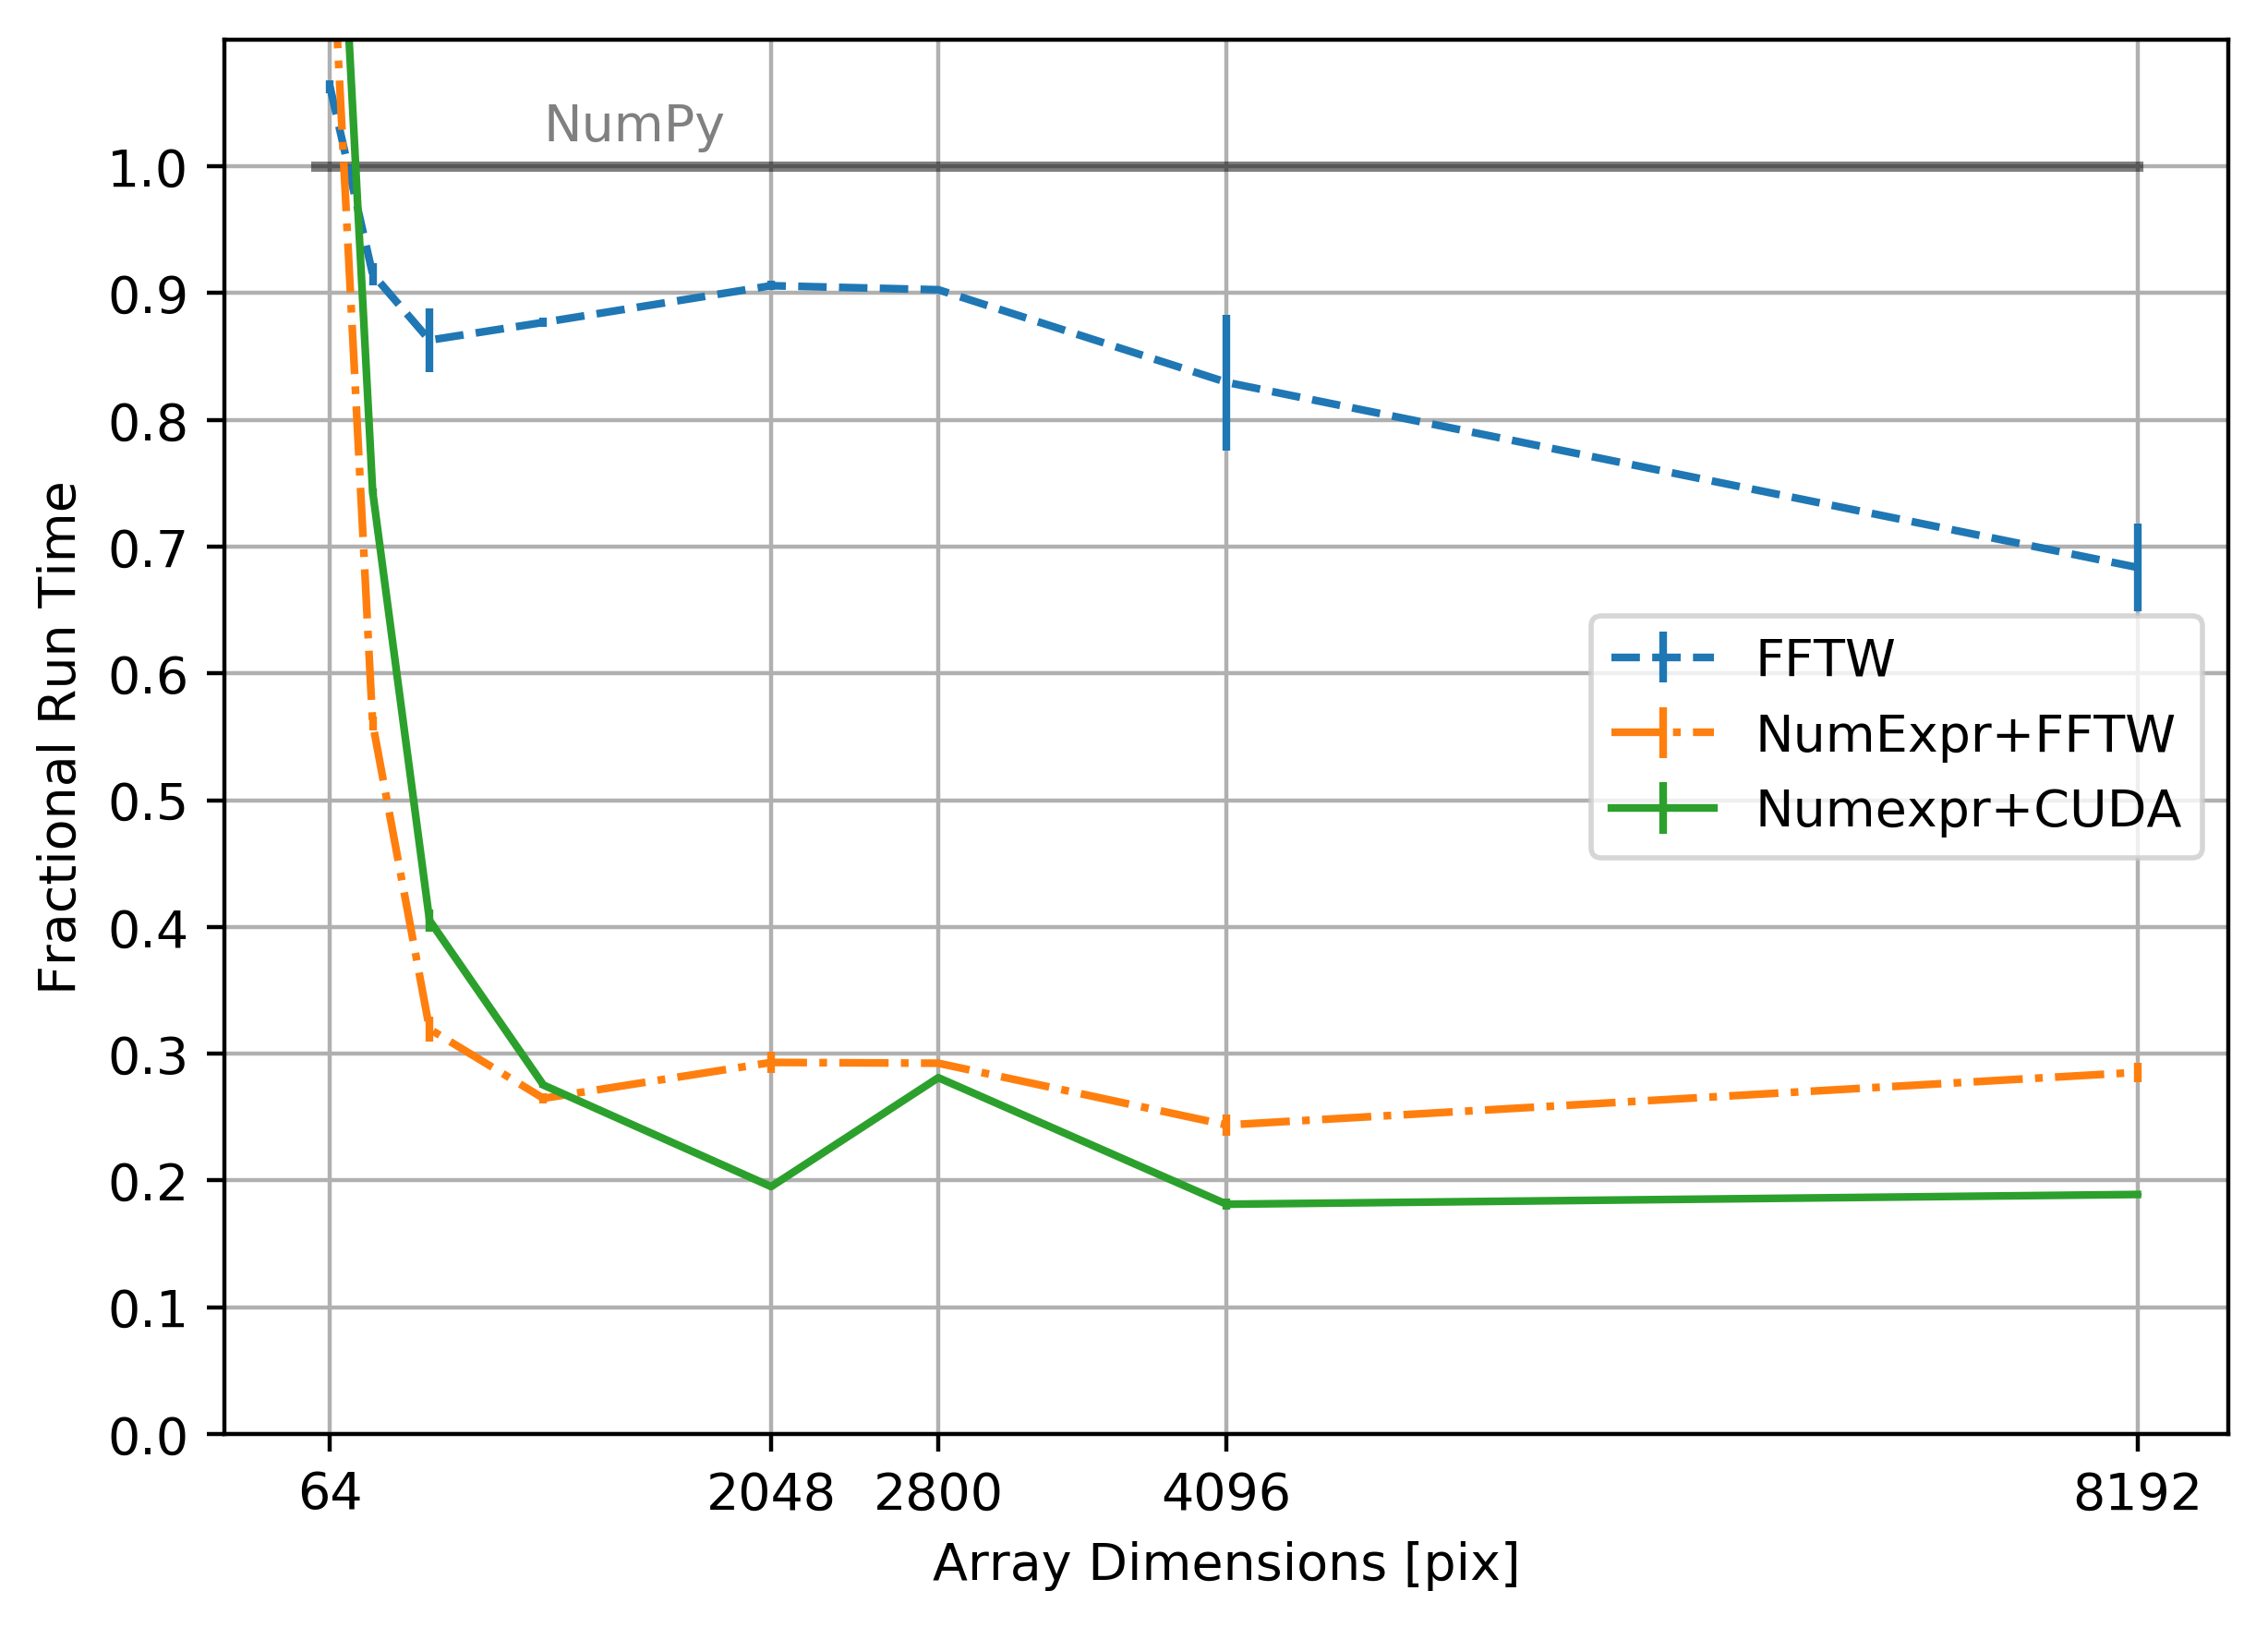

In [36]:
plt.figure(dpi=400, figsize=[7,5])
ax=plt.subplot(111)


y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)
#y["avg"].plot.bar(yerr=y["std"],
#                       xticks=pixlist,label="NumPy",color="orange",linestyle="--",
#                   alpha=.7,ax=ax)


y_FFTW=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(True)+'.csv',index_col=0)

#ax=y_cuda_numexpr["avg"].plot.bar(yerr=y_cuda_numexpr["std"],label="NumExpr+CUDA")
ax.errorbar(pixlist,y_FFTW["avg"]/y["avg"],
            yerr=y_FFTW["avg"]/y["avg"]*np.sqrt((y_FFTW["std"]/y_FFTW["avg"])**2+(y["std"]/y["avg"])**2),
            label="FFTW",linestyle="--" )

y_numexpr=pd.read_csv('cuda'+str(False)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_numexpr["avg"]/y["avg"],
            yerr=y_numexpr["avg"]/y["avg"]*np.sqrt((y_numexpr["std"]/y_numexpr["avg"])**2+(y["std"]/y["avg"])**2),
            label="NumExpr+FFTW",linestyle="-." )

y_all=pd.read_csv('cuda'+str(True)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_all["avg"]/y["avg"],
            yerr=y_all["avg"]/y["avg"]*np.sqrt((y_all["std"]/y_all["avg"])**2+(y["std"]/y["avg"])**2),

            label="Numexpr+CUDA",  )



ax.plot([0,np.max(pixlist)],[1,1],linewidth=2,alpha=.5,color="black")
ax.text(256,1.02,"NumPy",color="gray")
#plt.xscale("log")
ax.set_xticks([pixlist[0]]+list(pixlist[4:]))
#ax.set_xticks(range(len(pixlist)))
ax.set_xticklabels(np.int_(ax.get_xticks()/test_optsys.beam_ratio))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_ylabel("Fractional Run Time")
plt.legend()
plt.grid()
plt.xlabel("Array Dimensions [pix]")
plt.ylim([0,1.1])
#plt.yscale("log")
plt.savefig("benchmarks%icores.pdf"%(ne.ncores),bbox_inches="tight")


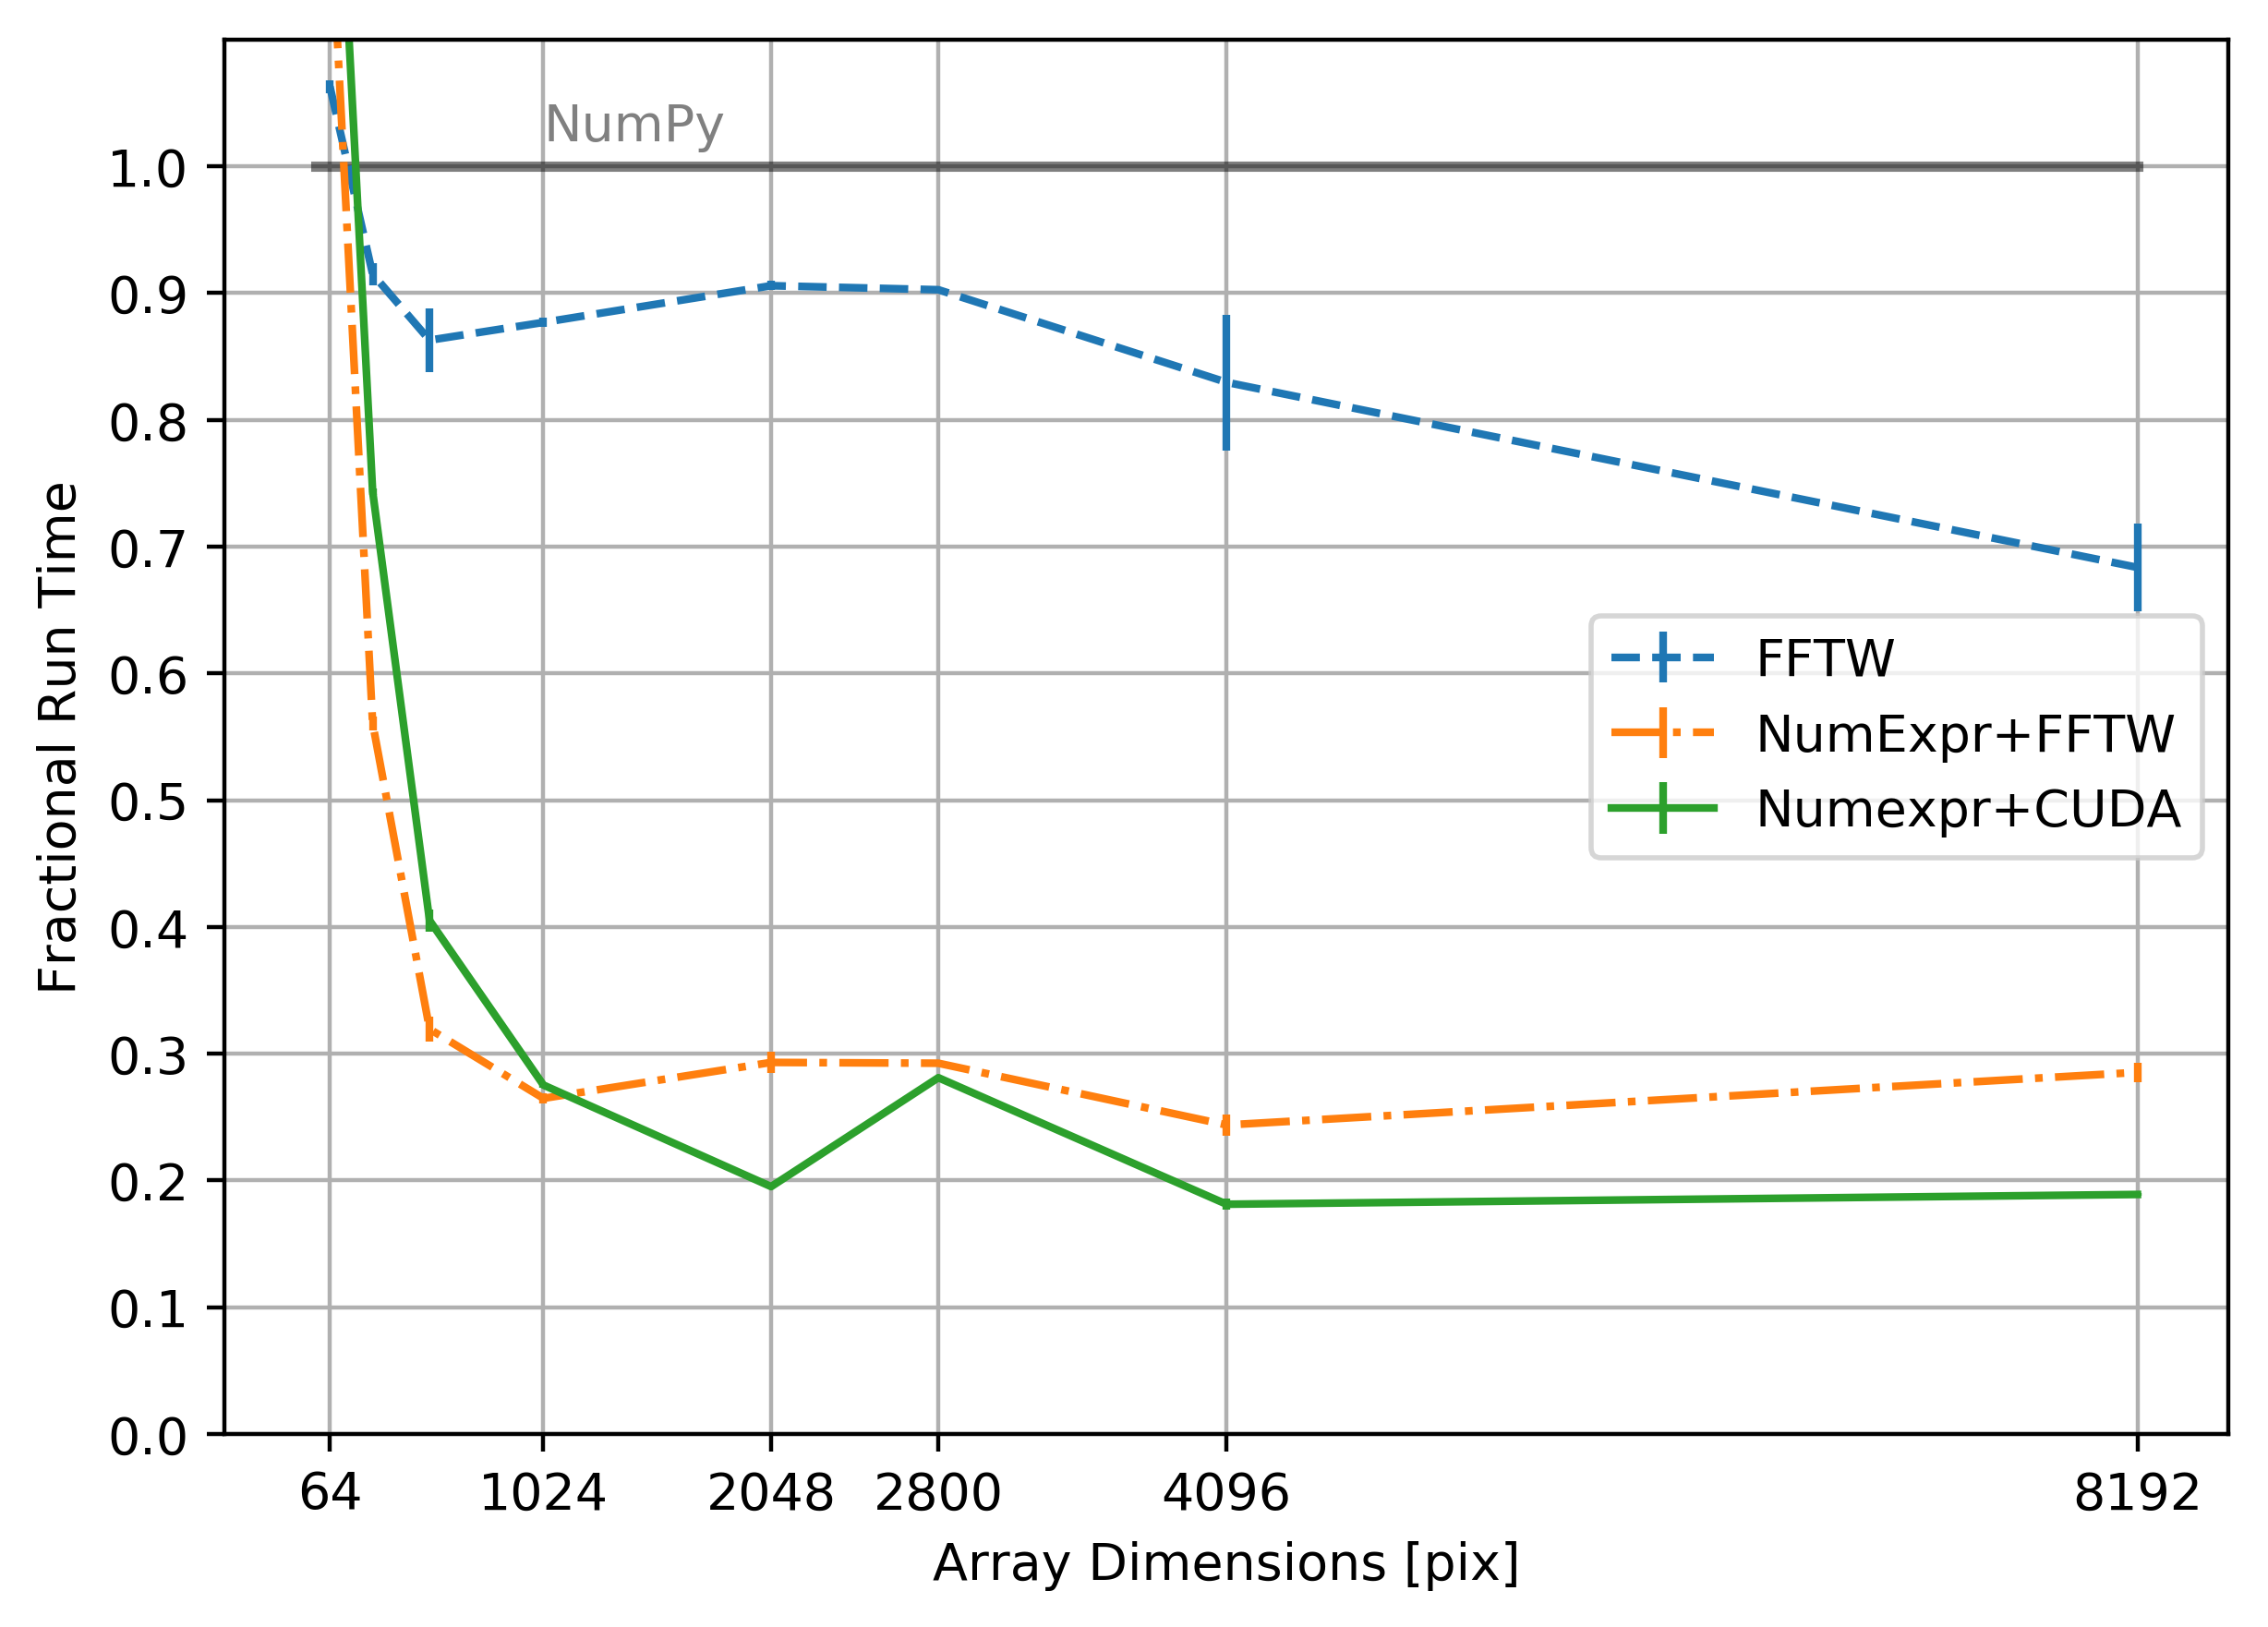

In [37]:
plt.figure(dpi=400, figsize=[7,5])
ax=plt.subplot(111)


y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)
#y["avg"].plot.bar(yerr=y["std"],
#                       xticks=pixlist,label="NumPy",color="orange",linestyle="--",
#                   alpha=.7,ax=ax)


y_FFTW=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(True)+'.csv',index_col=0)

#ax=y_cuda_numexpr["avg"].plot.bar(yerr=y_cuda_numexpr["std"],label="NumExpr+CUDA")
ax.errorbar(pixlist,y_FFTW["avg"]/y["avg"],
            yerr=y_FFTW["avg"]/y["avg"]*np.sqrt((y_FFTW["std"]/y_FFTW["avg"])**2+(y["std"]/y["avg"])**2),
            label="FFTW",linestyle="--" )

y_numexpr=pd.read_csv('cuda'+str(False)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_numexpr["avg"]/y["avg"],
            yerr=y_numexpr["avg"]/y["avg"]*np.sqrt((y_numexpr["std"]/y_numexpr["avg"])**2+(y["std"]/y["avg"])**2),
            label="NumExpr+FFTW",linestyle="-." )

y_all=pd.read_csv('cuda'+str(True)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)
#y_cuda["avg"].plot.bar(yerr=y_cuda["std"],
#                       xticks=pixlist,label="CUDA",color="orange",alpha=.7,ax=ax)

ax.errorbar(pixlist,y_all["avg"]/y["avg"],
            yerr=y_all["avg"]/y["avg"]*np.sqrt((y_all["std"]/y_all["avg"])**2+(y["std"]/y["avg"])**2),

            label="Numexpr+CUDA",  )



ax.plot([0,np.max(pixlist)],[1,1],linewidth=2,alpha=.5,color="black")
ax.text(256,1.02,"NumPy",color="gray")
#plt.xscale("log")
ax.set_xticks([pixlist[0]]+list(pixlist[3:]))
#ax.set_xticks(range(len(pixlist)))
ax.set_xticklabels(np.int_(ax.get_xticks()/test_optsys.beam_ratio))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_ylabel("Fractional Run Time")
plt.legend()
plt.grid()
plt.xlabel("Array Dimensions [pix]")
plt.ylim([0,1.1])
#plt.yscale("log")
plt.savefig("benchmarks%icores.pdf"%(ne.ncores),bbox_inches="tight")



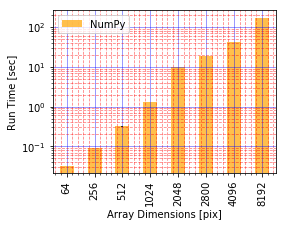

In [38]:
plt.figure(figsize=[4,3])
ax=plt.subplot(111)

ticks=np.int_(pixlist*4)
y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)
y["avg"].plot.bar(yerr=y["std"],
                       #ticks=ticks,
                  label="NumPy",color="orange",linestyle="--",
                   alpha=.7,ax=ax)

#ax.text(256,1.02,"NumPy",color="gray")
ax.set_ylabel("Run Time [sec]")
plt.legend()
plt.minorticks_on()

plt.grid(b=True, which='major', color='b', linestyle='-',alpha=.5)

plt.grid(b=True, which='minor', color='r', linestyle='--',alpha=.5)
plt.xlabel("Array Dimensions [pix]")
#plt.yscale("log")
plt.yscale("log")
ax.set_xticklabels(ticks)


plt.savefig("NumPy_runtime%icores.pdf"%(ne.ncores),bbox_inches="tight")

### where's the remaining bottleneck?

NumExpr evaluations still dominate

In [ ]:
psf_timing = %prun -r  -s  tottime  optsys(npix=2048,ratio=0.25).calcPSF(display_intermediates=False, return_intermediates=False)
psf_timing.print_stats()

In [ ]:
psf_timing = %prun -r  -s  tottime  optsys(npix=512,ratio=0.25).calcPSF(display_intermediates=False, return_intermediates=False)
psf_timing.print_stats()

## Talbot Effect Illustration

In [ ]:
import poppy
import astropy.units as u
sineWFE=poppy.wfe.SineWaveWFE(spatialfreq=500,amplitude=5e-9)
wf_f = poppy.fresnel.FresnelWavefront(beam_radius=2*u.cm,wavelength=0.5*u.um,npix=256,oversample=8)
wf_f*=sineWFE
Z_t=2*((1/sineWFE.sine_spatial_freq))**2/wf_f.wavelength
       
       
wf_f *= poppy.CircularAperture(radius=wf_f.diam/2)
wf_f.propagate_fresnel(Z_t/10000.)


plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



max_phase=6.28*(sineWFE.sine_amplitude/wf_f.wavelength).decompose()
amp_min=0.95
ax[0].images[0].set_clim(amp_min,1)
ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)

plt.tight_layout()
plt.savefig("zt0.pdf",bbox_inches="tight")



plt.figure(figsize=[8,4])

wf_f.propagate_fresnel(Z_t*.05-wf_f.z)
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())

plt.tight_layout()
plt.savefig("zt1.pdf",bbox_inches="tight")


wf_f.propagate_fresnel(Z_t*.25-wf_f.z)
plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle([(wf_f.z/Z_t).decompose(),np.std(wf_f.amplitude[wf_f.amplitude>1e-9])])
plt.tight_layout()


plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



plt.tight_layout()
plt.savefig("zt2.pdf",bbox_inches="tight")
print(Z_t.decompose())

# Old:

commit:4d86854bc2e709d7415ac8e9075098c7f9b4dc16

```%timeit  wfirst_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)```

```
5.8 s ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [16]:
```

commit:8049b9257a2239944f3ca5358462580d4a47804b
```
5.66 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [8]:
```getphasor percall: 0.353




In [ ]:
%%prun
poppy.conf.use_cuda=False
psf = optsys().calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)


In [ ]:
poppy.display_psf(psf)


In [ ]:
#exit_wf = waves[-1]
plt.imshow(np.log10(wf.intensity), cmap='gray', vmin=-6, vmax=0)
plt.colorbar()

## Old benchmarks:

##  83e5e2d3be3240c2867a02f8e89c7b1802cb3a4e


environment accelerate 83e5e2d3be3240c2867a02f8e89c7b1802cb3a4e:

`ne.ncores,ne.nthreads,ne.show_config()`

```mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/miniconda3/envs/anaconda/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/miniconda3/envs/anaconda/include']
Out[29]:
(8, 8, None)
```

### standard install with np.fft
```
1.58 s ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.2 s ± 710 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2min 8s ± 3.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
```
### standard install with pyfftw:
```
1.21 s ± 32.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 34s ± 791 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

```
### NumExpr but no cuda:


```
959 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.5 s ± 726 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 22s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

### NumExpr +  cuda, 2x faster:
```
497 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.23 s ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [ ]:
exit_wf.n